# Exercise Optical Tweezers chapter

### David Bronte Ciriza, Maria G. Donato and Onofrio M. Maragò.

Here a small tutorial solving the exercise in the chapter and showing how to analyse optical tweezers experimental data.

#### Exercise 1: Calibration of optical tweezers using the power spectrum


You are given some experimental measurements of a trapped spherical $2\,\mu m$ diameter particle at room temperature. You can find the data at:

github.com/brontecir/ExerciseOpticalTweezers/tree/main/ProblemForAM_Book/Exercise

a) Remove from the tracking signals their average value, as we are interested only in particle fluctuations around the trap equilibrium position.

b) Calculate the power spectra (writing code). Fit the PSDs with the Lorentzian model in Eq. 13. Can you reproduce the results of Fig 6?

#### Exercise 2: Calibration of optical tweezers using the ACF

For the same experimental data as in the previous exercise, perform the calibration using the autocorrelation function method. 

Calculate the autocorrelation function (ACF). Fit the ACFs with a single exponential decay, with and without the addition of a constant offset. Can you reproduce what is obtained in Fig 6?

#### Exercise 3: Calibration of optical tweezers using FORMA

For the same experimental data as in the previous exercise, perform the calibration using FORMA. 

a) Using Eq. 24, can you reproduce what is obtained in Fig 6?

b) Compare the different calibration methods with each other. What are the advantages of each of them?

Let's start solving them:

We first import the required libraries

In [1]:
import numpy as np
import math
import random

import os

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import statistics as stats
from scipy.stats import skew
import scipy.fftpack
from scipy.optimize import curve_fit

And we define some magnitudes for plotting the figures

In [2]:
VERYSMALL_SIZE=15
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes\n",
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title\n",
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize\n",
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titl\n",

C1='#2CBDFE'
C2='#9D2EC5'
C3='#F5B14C'

We define function to load our data:

In [3]:
def ReadingFileWithTime(FileName):

    f=open(FileName, "r")
    content=f.readlines()

    s=len(content)

    t=np.zeros(s)
    x_volt_meas=np.zeros(s)
    y_volt_meas=np.zeros(s)
    z_volt_meas=np.zeros(s)
       
    for i in range (s):
        row=content[i].split("\t")
        t[i]=float(row[1])
        x_volt_meas[i]=float(row[2])
        y_volt_meas[i]=float(row[3])
        z_volt_meas[i]=float(row[4])
    
    positions_Volts=[t,x_volt_meas,y_volt_meas,z_volt_meas]
    return positions_Volts

We load one file of data:

In [4]:
FolderThatContainsFiles = ".\\Exercise"
my_file = os.path.join(FolderThatContainsFiles, 'D0b2_10.txt')
Data=ReadingFileWithTime(my_file)

We plot the voltage measurements obtained from the QPD

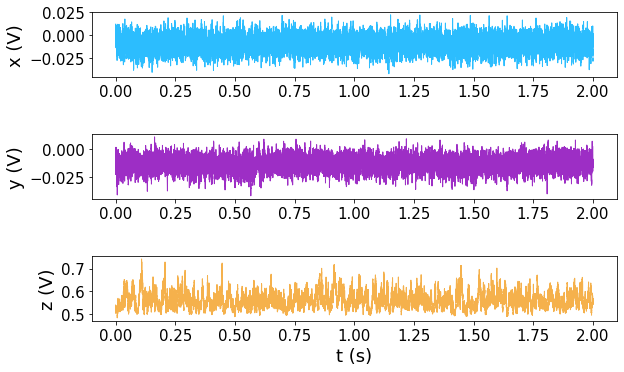

In [5]:
fig = plt.figure()

ax1 = plt.subplot(3,1,1)
ax1.plot(Data[0],Data[1], linewidth=1,c=C1)
ax1.set_ylabel("x (V)")

# and a reference to the second axis
ax2 = plt.subplot(3,1,2)
ax2.plot(Data[0],Data[2], linewidth=1,c=C2)
ax2.set_ylabel("y (V)")

ax3 = plt.subplot(3,1,3)
ax3.plot(Data[0],Data[3], linewidth=1,c=C3)
ax3.set_ylabel("z (V)")
ax3.set_xlabel("t (s)")

fig.tight_layout()


plt.gcf().set_size_inches(10, 6)

We substract the mean:

In [6]:
DataMeanSubstracted=[Data[0],Data[1]-Data[1].mean(),Data[2]-Data[2].mean(),Data[3]-Data[3].mean()]

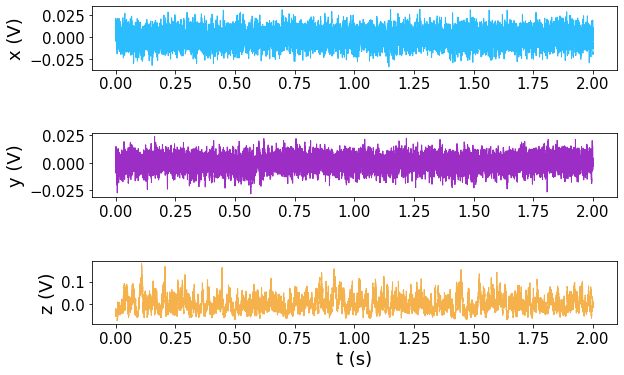

In [7]:
fig = plt.figure()


ax1 = plt.subplot(3,1,1)
ax1.plot(DataMeanSubstracted[0],DataMeanSubstracted[1], linewidth=1,c=C1)
ax1.set_ylabel("x (V)")

# and a reference to the second axis
ax2 = plt.subplot(3,1,2)
ax2.plot(DataMeanSubstracted[0],DataMeanSubstracted[2], linewidth=1,c=C2)
ax2.set_ylabel("y (V)")

ax3 = plt.subplot(3,1,3)
ax3.plot(DataMeanSubstracted[0],DataMeanSubstracted[3], linewidth=1,c=C3)
ax3.set_ylabel("z (V)")
ax3.set_xlabel("t (s)")

fig.tight_layout()

plt.gcf().set_size_inches(10, 6)

We can already see that the fluctuations across the $z$ axis are much larger than across the $x$ and $y$ directions.

Let's plot an histogram of the distribution. How does it look?

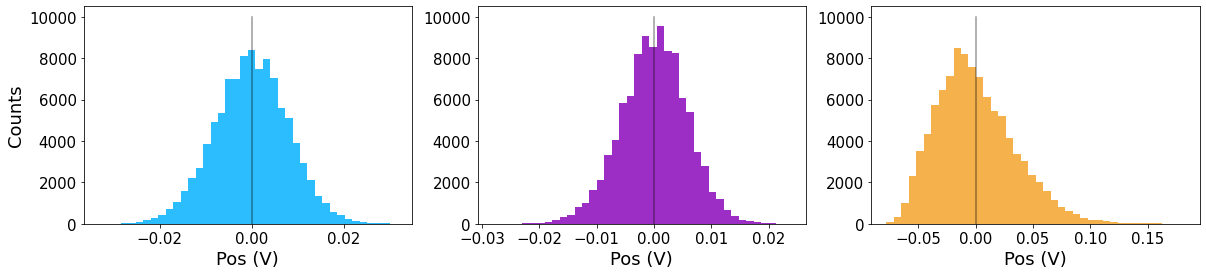

In [8]:
fig = plt.figure()


ax1 = plt.subplot(1,3,1)
ax1.hist(DataMeanSubstracted[1],40,color=C1)
ax1.plot([0,0],[0,10000],c='k',alpha=0.4)
ax1.set_ylabel("Counts")
ax1.set_xlabel("Pos (V)")

# and a reference to the second axis
ax2 = plt.subplot(1,3,2)
ax2.hist(DataMeanSubstracted[2],40,color=C2)
ax2.plot([0,0],[0,10000],c='k',alpha=0.4)
ax2.set_xlabel("Pos (V)")

ax3 = plt.subplot(1,3,3)
ax3.hist(DataMeanSubstracted[3],40,color=C3)
ax3.plot([0,0],[0,10000],c='k',alpha=0.4)
ax3.set_xlabel("Pos (V)")

#fig.tight_layout()

plt.gcf().set_size_inches(20, 4)

Now we are ready to start calibrating the optical trap

Let's define the parameters of our experiment

In [9]:
kB=1.3806E-23       # [(kg·m^2)/(K·s^2)]
T = 273+20          # [K]
Radius = 1E-6    # [m]
#Check viscosity value
Viscosity = 0.00002414*10**(247.8/(-140+T))  # [Pa·s]
Gamma = 6*math.pi*Viscosity*Radius

## Power spectrum


We start by calculating the power spectrum. We focus on one single measurement (for simplicity)

In [10]:
"""
Function to compute the Power Spectrum.
Input: Frequency of sampling [Hz], Variable[AnyUnits]
Output: [Freqs, Power Spectrum]

"""

def PS(frequency_of_sampling,position_Volts):
    
    s=len(position_Volts)

    freq=np.arange(0,frequency_of_sampling/2,frequency_of_sampling/(s))

    FFT=scipy.fftpack.fft(position_Volts)
    FFT_one_side=FFT[0:int(s/2)]
    
    psd=2*((np.abs(FFT_one_side))**2)/(frequency_of_sampling*s)
    
    return([freq[1:],psd[1:]])

We calculate the sampling frequency

In [11]:
freq_sampling=1/(DataMeanSubstracted[0][1]-DataMeanSubstracted[0][0])

And we compute the power spectrum

In [12]:
PS_calculatedX=PS(freq_sampling,DataMeanSubstracted[1])
PS_calculatedY=PS(freq_sampling,DataMeanSubstracted[2])
PS_calculatedZ=PS(freq_sampling,DataMeanSubstracted[3])

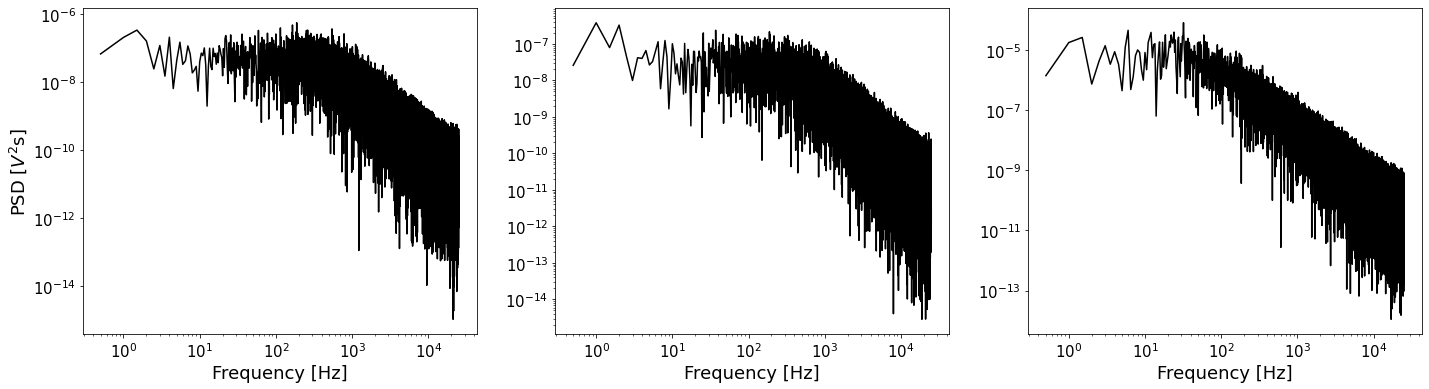

In [13]:
fig = plt.figure()


ax1 = plt.subplot(1,3,1)
ax1.plot(PS_calculatedX[0],PS_calculatedX[1], c='k')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel("PSD [$V^2$s]")
ax1.set_xlabel("Frequency [Hz]")

ax2 = plt.subplot(1,3,2)
ax2.plot(PS_calculatedY[0],PS_calculatedY[1], c='k')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Frequency [Hz]")

ax3 = plt.subplot(1,3,3)
ax3.plot(PS_calculatedZ[0],PS_calculatedZ[1], c='k')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel("Frequency [Hz]")

#fig.tight_layout()

plt.gcf().set_size_inches(24, 6)

We define the fitting function and the function we will use to obtain the parameters after the fitting.

In [14]:
def FuncToFitPS(x, a, b):
    return a /( (x**2)+(b**2) )

In [15]:
def FittingPS(frequencies,psd,NPoints):

    popt, pcov = curve_fit(FuncToFitPS,frequencies[0:NPoints],psd[0:NPoints],p0=[10000000,444])
    
    PS_K_SI=2*Gamma*np.pi*popt[1]   
    PS_Beta=np.sqrt( FuncToFitPS(0,popt[0],popt[1])*popt[1]*popt[1]*np.pi*Gamma/(kB*T)     )
    #PS_Beta=1/np.sqrt( (kB*T)/(popt[0]*Gamma*np.pi*np.pi)     )
    
    ToReturn0=[frequencies[0:NPoints],FuncToFitPS(frequencies[0:NPoints], popt[0], popt[1])]
    ToReturn1=[PS_K_SI,PS_Beta]
    
    return([ToReturn0,ToReturn1])

In [16]:
Fitted_PS_X=FittingPS(PS_calculatedX[0],PS_calculatedX[1],10000)
Fitted_PS_Y=FittingPS(PS_calculatedY[0],PS_calculatedY[1],10000)
Fitted_PS_Z=FittingPS(PS_calculatedZ[0],PS_calculatedZ[1],10000)

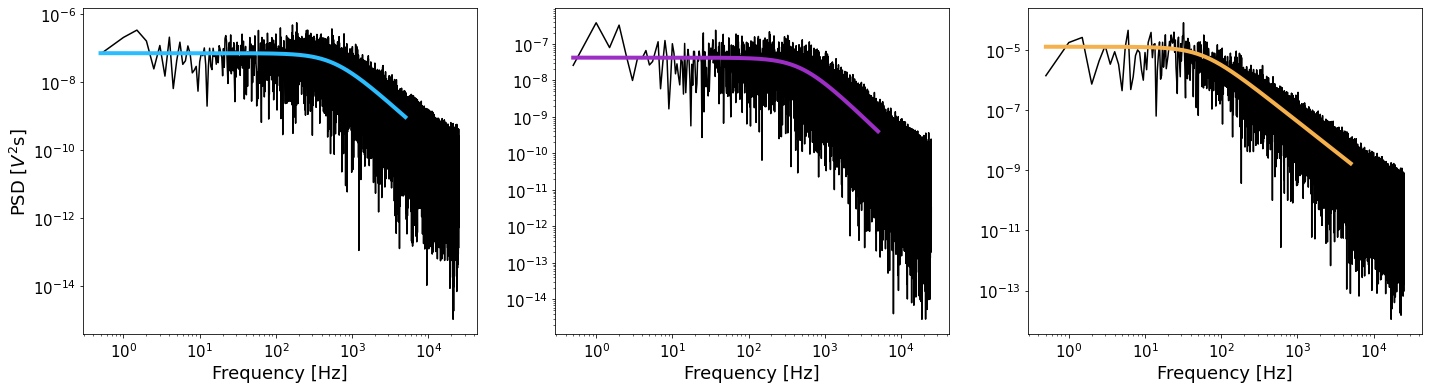

In [17]:
fig = plt.figure()


ax1 = plt.subplot(1,3,1)
ax1.plot(PS_calculatedX[0],PS_calculatedX[1], c='k')
ax1.plot(Fitted_PS_X[0][0], Fitted_PS_X[0][1], linewidth=4, c=C1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel("PSD [$V^2$s]")
ax1.set_xlabel("Frequency [Hz]")

ax2 = plt.subplot(1,3,2)
ax2.plot(PS_calculatedY[0],PS_calculatedY[1], c='k')
ax2.plot(Fitted_PS_Y[0][0], Fitted_PS_Y[0][1], linewidth=4, c=C2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Frequency [Hz]")

ax3 = plt.subplot(1,3,3)
ax3.plot(PS_calculatedZ[0],PS_calculatedZ[1], c='k')
ax3.plot(Fitted_PS_Z[0][0], Fitted_PS_Z[0][1], linewidth=4, c=C3)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel("Frequency [Hz]")

#fig.tight_layout()

plt.gcf().set_size_inches(24, 6)

plt.savefig('.\\PS.svg', format='svg', transparent=True,bbox_inches='tight')

The value of $k\,[pN/\mu m]$

In [18]:
Fitted_PS_X[1][0]

6.898475128864362e-05

In [19]:
Fitted_PS_Y[1][0]

5.857617188758282e-05

In [20]:
Fitted_PS_Z[1][0]

6.808258575947718e-06

The value of $\beta\,[V/m]$

In [21]:
Fitted_PS_X[1][1]

594311.0395101135

In [22]:
Fitted_PS_Y[1][1]

387873.3912106273

In [23]:
Fitted_PS_Z[1][1]

794072.3202039044

## Autocorrelation function

We calculate now the autocorrelation function. 

In [24]:
"""
Function to compute the Autocorrelation Function.
Input: Time[s],Variable[AnyUnits],MaxTimeStepsCompute
Output: [Time,AutocorrelationFunction]

"""

def ACF(time,position_Volts,MaxTimeDistance):

    AutoCorrelationFunction=np.zeros(MaxTimeDistance)
    
    s=len(position_Volts)
    
    sum1=0

    for i in range (0,MaxTimeDistance):
        for j in range(0,s-i):
            aux1=position_Volts[j+i]*position_Volts[j]
            sum1=sum1+aux1;
            AutoCorrelationFunction[i]=(1/(s-i))*sum1
        sum1=0
    
    t_ACF=time[0:int(MaxTimeDistance)]
    
    AutoCorrelationFunction_def=AutoCorrelationFunction[0:(s)]
    t_ACF_def=t_ACF[0:(s)]

    return([t_ACF_def,AutoCorrelationFunction_def])

The method used to compute the ACF is very slow, you can use prebuilt functions to improve it!

In [49]:
ACF_calculatedX=ACF(DataMeanSubstracted[0],DataMeanSubstracted[1],600)
ACF_calculatedY=ACF(DataMeanSubstracted[0],DataMeanSubstracted[2],600)
ACF_calculatedZ=ACF(DataMeanSubstracted[0],DataMeanSubstracted[3],1200)

We observe the exponential decay we are expecting. 

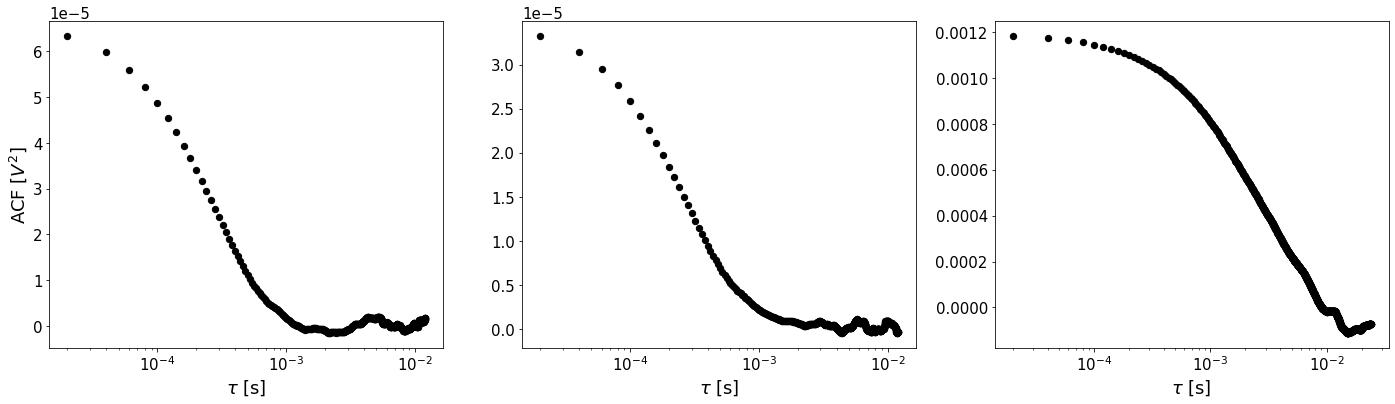

In [50]:
fig = plt.figure()


ax1 = plt.subplot(1,3,1)
ax1.scatter(ACF_calculatedX[0],ACF_calculatedX[1], s=40, c='k')
ax1.set_xscale('log')
ax1.set_ylabel("ACF [$V^2$]")
ax1.set_xlabel(r'$\tau$ [s]')

ax2 = plt.subplot(1,3,2)
ax2.scatter(ACF_calculatedY[0],ACF_calculatedY[1], s=40, c='k')
ax2.set_xscale('log')
ax2.set_xlabel(r'$\tau$ [s]')

ax3 = plt.subplot(1,3,3)
ax3.scatter(ACF_calculatedZ[0],ACF_calculatedZ[1], s=40, c='k')
ax3.set_xscale('log')
ax3.set_xlabel(r'$\tau$ [s]')

#fig.tight_layout()

plt.gcf().set_size_inches(24, 6)

Now that we have the ACF we need to fit it to the theoretical expression in order to obtain the parameters for the stiffness $k$ and for the conversion factor $\beta$

In [51]:
def FuncToFitACF(x, a, b,c):
    return (a * np.exp(-b * x))+c

In [52]:
"""
Function to fit the experimental ACF to the theoretical ACF.
Input: Time[s],ACF values, Number of time steps that we want to consider for the fitting
Output: [Time considered for fitting, Fitted curve]
        [Value of K [N/m], Value of beta [V/m]]

"""

def FittingACF(t_ACF_def,AutoCorrelationFunction_def,NPoints):

    popt, pcov = curve_fit(FuncToFitACF,t_ACF_def[0:NPoints],AutoCorrelationFunction_def[0:NPoints],p0=[0.00008,700,0])
    
    ACF_K_SI=popt[1]*Gamma
    ACF_Beta=np.sqrt((popt[0]*ACF_K_SI)/(kB*T))
    
    ToReturn0=[t_ACF_def[0:NPoints],FuncToFitACF(t_ACF_def[0:NPoints], popt[0], popt[1],popt[2])]
    ToReturn1=[ACF_K_SI,ACF_Beta]
    
    return([ToReturn0,ToReturn1])

In [53]:
Fitted_ACF_X=FittingACF(ACF_calculatedX[0],ACF_calculatedX[1],300)
Fitted_ACF_Y=FittingACF(ACF_calculatedY[0],ACF_calculatedY[1],300)
Fitted_ACF_Z=FittingACF(ACF_calculatedZ[0],ACF_calculatedZ[1],400)

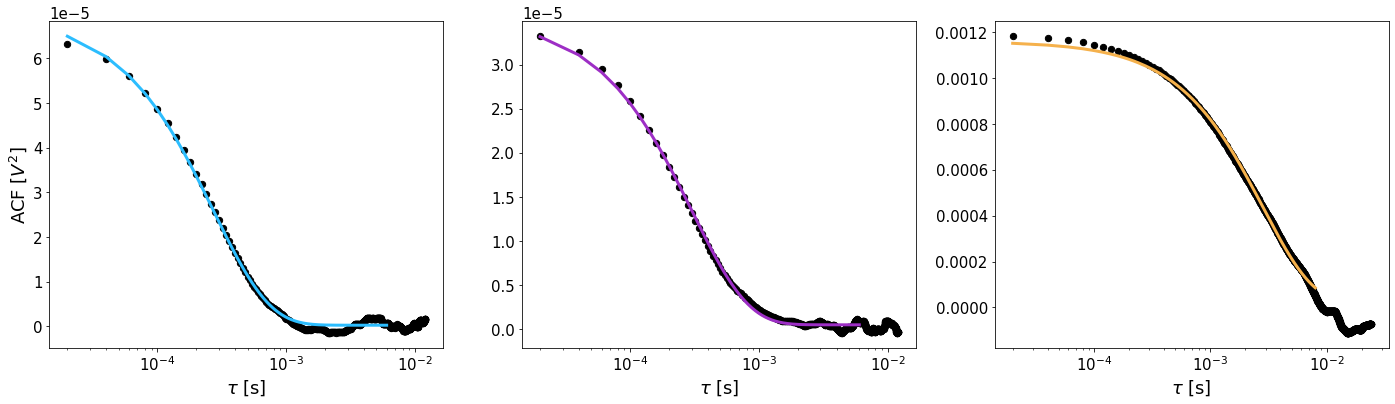

In [54]:
fig = plt.figure()


ax1 = plt.subplot(1,3,1)
ax1.scatter(ACF_calculatedX[0],ACF_calculatedX[1], s=40, c='k')
ax1.plot(Fitted_ACF_X[0][0], Fitted_ACF_X[0][1], linewidth=3, c=C1)
ax1.set_xscale('log')
ax1.set_ylabel("ACF [$V^2$]")
ax1.set_xlabel(r'$\tau$ [s]')

ax2 = plt.subplot(1,3,2)
ax2.scatter(ACF_calculatedY[0],ACF_calculatedY[1], s=40, c='k')
ax2.plot(Fitted_ACF_Y[0][0], Fitted_ACF_Y[0][1], linewidth=3, c=C2)
ax2.set_xscale('log')
ax2.set_xlabel(r'$\tau$ [s]')

ax3 = plt.subplot(1,3,3)
ax3.scatter(ACF_calculatedZ[0],ACF_calculatedZ[1], s=40, c='k')
ax3.plot(Fitted_ACF_Z[0][0], Fitted_ACF_Z[0][1], linewidth=3, c=C3)
ax3.set_xscale('log')
ax3.set_xlabel(r'$\tau$ [s]')

#fig.tight_layout()

plt.gcf().set_size_inches(24, 6)

plt.savefig('.\\ACF.svg', format='svg', transparent=True,bbox_inches='tight')

The value of $k\,[pN/\mu m]$

In [55]:
Fitted_ACF_X[1][0]

6.96018737168294e-05

In [56]:
Fitted_ACF_Y[1][0]

6.237479454787732e-05

In [57]:
Fitted_ACF_Z[1][0]

6.694198418821306e-06

The value of $\beta \, [V/m]$

In [58]:
Fitted_ACF_X[1][1]

1094301.1402910848

In [59]:
Fitted_ACF_Y[1][1]

733852.4350936494

In [60]:
Fitted_ACF_Z[1][1]

1373638.0809098133

## FORMA

Let us focus now on FORMA

In [61]:
def FORMAMethod(dt,Position):
    
    position=Position
    s=len(position)

    aux1=position

    Speeds=np.zeros(s-1)

    for i in range (s-1):
        Speeds[i]=(aux1[i+1]-aux1[i])/dt
            
    f_n=Speeds*Gamma

    positions_n_by_f_n=position[0:s-1]*f_n
    x_n_squared=position[0:s-1]*position[0:s-1]

    K_FORMA=(sum(positions_n_by_f_n))/sum(x_n_squared)
    
    ToReturn0=[position[0:s-1],f_n]
    ToReturn1=[K_FORMA]
    
    return([ToReturn0,ToReturn1])

In [62]:
dt=DataMeanSubstracted[0][1]-DataMeanSubstracted[0][0]

In [63]:
FORMA_calculatedX=FORMAMethod(dt,DataMeanSubstracted[1])
FORMA_calculatedY=FORMAMethod(dt,DataMeanSubstracted[2])
FORMA_calculatedZ=FORMAMethod(dt,DataMeanSubstracted[3])

We plot $f_n$ vs $x_n$

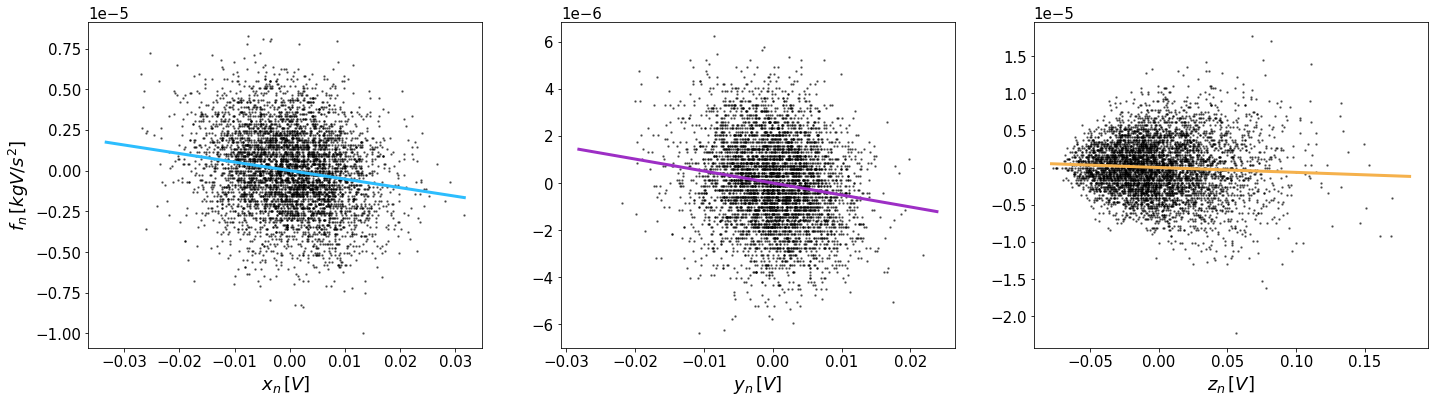

In [64]:
fig = plt.figure()

ax1 = plt.subplot(1,3,1)
ax1.scatter(FORMA_calculatedX[0][0][::20],FORMA_calculatedX[0][1][::20],s=2,c='k',alpha=0.5)
ax1.plot([min(FORMA_calculatedX[0][0]),max(FORMA_calculatedX[0][0])],[min(FORMA_calculatedX[0][0])*FORMA_calculatedX[1][0],max(FORMA_calculatedX[0][0])*FORMA_calculatedX[1][0]],linewidth=3,c=C1)
ax1.set_ylabel("$f_n\,[kg V/s^2]$")
ax1.set_xlabel("$x_n\,[V]$")

ax2 = plt.subplot(1,3,2)
ax2.scatter(FORMA_calculatedY[0][0][::20],FORMA_calculatedY[0][1][::20],s=2,c='k',alpha=0.5)
ax2.plot([min(FORMA_calculatedY[0][0]),max(FORMA_calculatedY[0][0])],[min(FORMA_calculatedY[0][0])*FORMA_calculatedY[1][0],max(FORMA_calculatedY[0][0])*FORMA_calculatedY[1][0]],linewidth=3,c=C2)
ax2.set_xlabel("$y_n\,[V]$")

ax3 = plt.subplot(1,3,3)
ax3.scatter(FORMA_calculatedZ[0][0][::20],FORMA_calculatedZ[0][1][::20],s=2,c='k',alpha=0.5)
ax3.plot([min(FORMA_calculatedZ[0][0]),max(FORMA_calculatedZ[0][0])],[min(FORMA_calculatedZ[0][0])*FORMA_calculatedZ[1][0],max(FORMA_calculatedZ[0][0])*FORMA_calculatedZ[1][0]],linewidth=3,c=C3)
ax3.set_xlabel("$z_n\,[V]$")

#fig.tight_layout()

plt.gcf().set_size_inches(24, 6)

#plt.savefig('.\\FORMA.svg', format='svg', transparent=True,bbox_inches='tight')

The value of $k\,[pN/\mu m]$

In [65]:
abs(FORMA_calculatedX[1][0])

5.246317435463358e-05

In [66]:
abs(FORMA_calculatedY[1][0])

5.080943040127781e-05

In [67]:
abs(FORMA_calculatedZ[1][0])

6.541490910568713e-06

In [95]:
VERYSMALL_SIZE=18
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes\n",
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title\n",
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize\n",
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titl\n",

C1='#2CBDFE'
C2='#9D2EC5'
C3='#F5B14C'

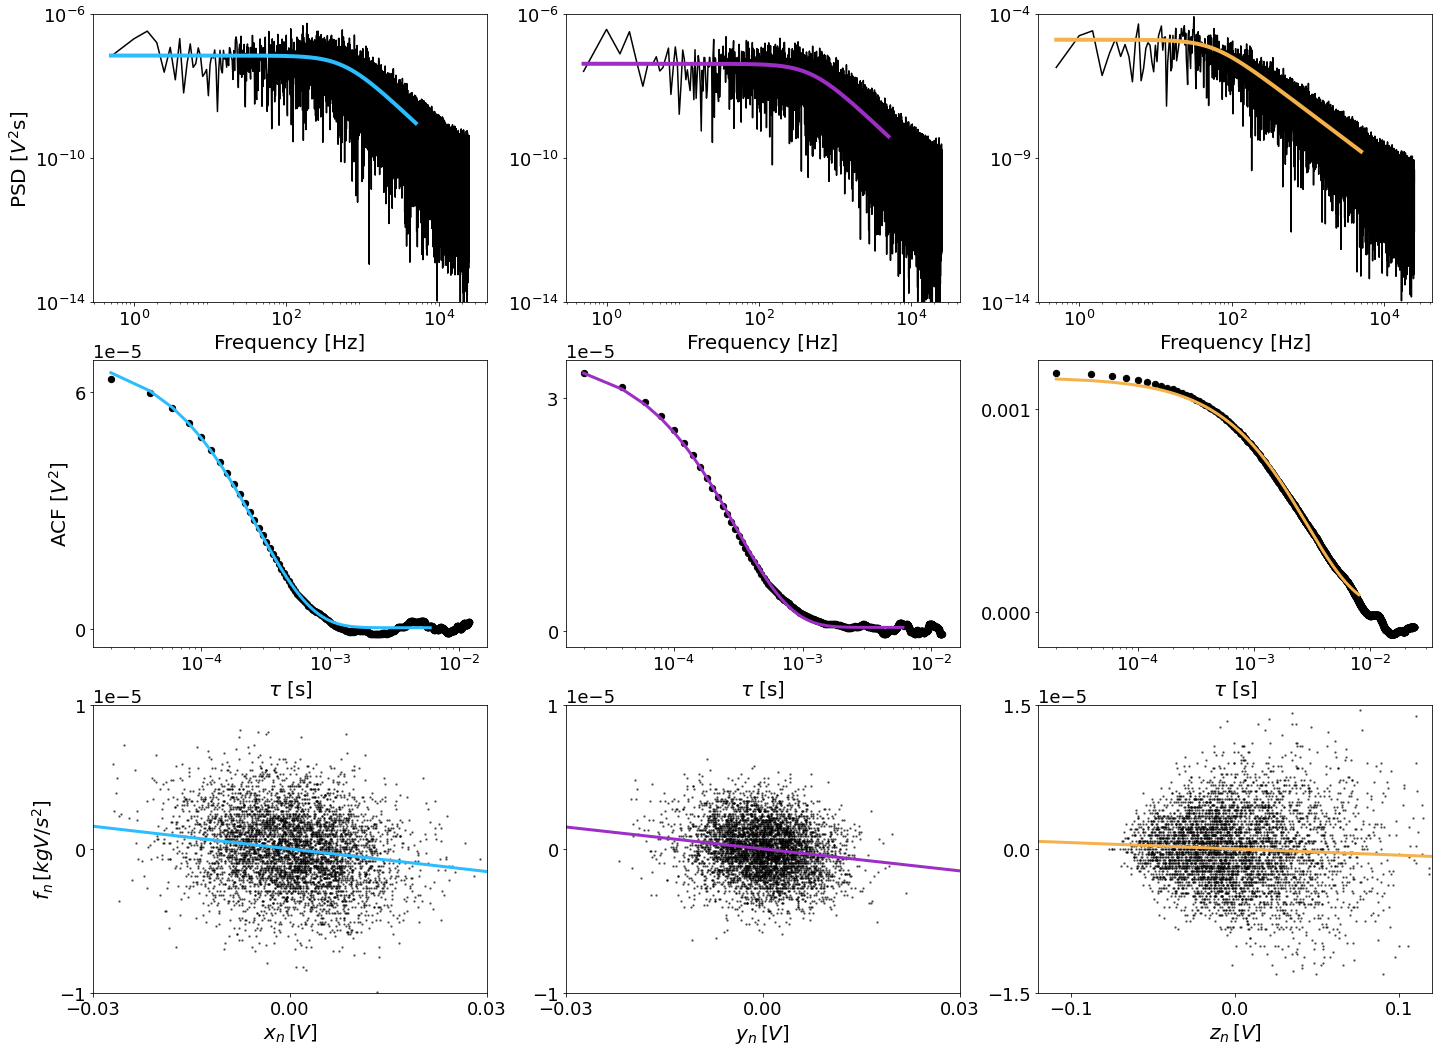

In [96]:
fig = plt.figure()

ax1 = plt.subplot(3,3,1)
ax1.plot(PS_calculatedX[0],PS_calculatedX[1], c='k')
ax1.plot(Fitted_PS_X[0][0], Fitted_PS_X[0][1], linewidth=4, c=C1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel("PSD [$V^2$s]")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylim([1E-14,1E-6])
ax1.set_yticks([1E-14,1E-10,1E-6])
ax1.set_xticks([1E0,1E2,1E4])


ax2 = plt.subplot(3,3,2)
ax2.plot(PS_calculatedY[0],PS_calculatedY[1], c='k')
ax2.plot(Fitted_PS_Y[0][0], Fitted_PS_Y[0][1], linewidth=4, c=C2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylim([1E-14,1E-6])
ax2.set_yticks([1E-14,1E-10,1E-6])
ax2.set_xticks([1E0,1E2,1E4])

ax3 = plt.subplot(3,3,3)
ax3.plot(PS_calculatedZ[0],PS_calculatedZ[1], c='k')
ax3.plot(Fitted_PS_Z[0][0], Fitted_PS_Z[0][1], linewidth=4, c=C3)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel("Frequency [Hz]")
ax3.set_ylim([1E-14,1E-4])
ax3.set_yticks([1E-14,1E-9,1E-4])
ax3.set_xticks([1E0,1E2,1E4])


ax4 = plt.subplot(3,3,4)
ax4.scatter(ACF_calculatedX[0],ACF_calculatedX[1], s=40, c='k')
ax4.plot(Fitted_ACF_X[0][0], Fitted_ACF_X[0][1], linewidth=3, c=C1)
ax4.set_xscale('log')
ax4.set_ylabel("ACF [$V^2$]")
ax4.set_xlabel(r'$\tau$ [s]')
ax4.set_yticks([0,6E-5])



ax5 = plt.subplot(3,3,5)
ax5.scatter(ACF_calculatedY[0],ACF_calculatedY[1], s=40, c='k')
ax5.plot(Fitted_ACF_Y[0][0], Fitted_ACF_Y[0][1], linewidth=3, c=C2)
ax5.set_xscale('log')
ax5.set_xlabel(r'$\tau$ [s]')
ax5.set_yticks([0,3E-5])

ax6 = plt.subplot(3,3,6)
ax6.scatter(ACF_calculatedZ[0],ACF_calculatedZ[1], s=40, c='k')
ax6.plot(Fitted_ACF_Z[0][0], Fitted_ACF_Z[0][1], linewidth=3, c=C3)
ax6.set_xscale('log')
ax6.set_xlabel(r'$\tau$ [s]')
ax6.set_yticks([0,1E-3])


ax7 = plt.subplot(3,3,7)
ax7.scatter(FORMA_calculatedX[0][0][::20],FORMA_calculatedX[0][1][::20],s=2,c='k',alpha=0.5)
ax7.plot([min(FORMA_calculatedX[0][0]),max(FORMA_calculatedX[0][0])],[min(FORMA_calculatedX[0][0])*FORMA_calculatedX[1][0],max(FORMA_calculatedX[0][0])*FORMA_calculatedX[1][0]],linewidth=3,c=C1)
ax7.set_ylabel("$f_n\,[kg V/s^2]$")
ax7.set_xlabel("$x_n\,[V]$")
ax7.set_xlim([-0.03,0.03])
ax7.set_ylim([-1E-5,1E-5])
ax7.set_yticks([-1E-5,0,1E-5])
ax7.set_xticks([-0.03,0,0.03])


ax8 = plt.subplot(3,3,8)
ax8.scatter(FORMA_calculatedY[0][0][::20],FORMA_calculatedY[0][1][::20],s=2,c='k',alpha=0.5)
ax8.plot([-0.03,0.03],[-0.03*FORMA_calculatedY[1][0],0.03*FORMA_calculatedY[1][0]],linewidth=3,c=C2)
ax8.set_xlabel("$y_n\,[V]$")

ax8.set_xlim([-0.03,0.03])
ax8.set_ylim([-1E-5,1E-5])
ax8.set_yticks([-1E-5,0,1E-5])
ax8.set_xticks([-0.03,0,0.03])

ax9 = plt.subplot(3,3,9)
ax9.scatter(FORMA_calculatedZ[0][0][::20],FORMA_calculatedZ[0][1][::20],s=2,c='k',alpha=0.5)
ax9.plot([-0.12,0.12],[-0.12*FORMA_calculatedZ[1][0],0.12*FORMA_calculatedZ[1][0]],linewidth=3,c=C3)
ax9.set_xlabel("$z_n\,[V]$")
ax9.set_xlim([-0.12,0.12])
ax9.set_ylim([-1.5E-5,1.5E-5])
ax9.set_yticks([-1.5E-5,0,1.5E-5])
ax9.set_xticks([-0.1,0,0.1])

#fig.tight_layout()

plt.gcf().set_size_inches(24, 18)

plt.savefig('.\\AllTogether.svg', format='svg', transparent=True,bbox_inches='tight')

## Averaging

Now we have fully analysed one measurement but we need to analyze more in order to get some statistics. We have 10 files, let's go!

We import the data and substract the mean

In [121]:
AllData=np.zeros([10,4,100000])
FolderThatContainsFiles = ".\\Exercise"

for i in range (1,11):
    my_file = os.path.join(FolderThatContainsFiles, 'D0b2_'+str(i)+'.txt')
    Data=ReadingFileWithTime(my_file)
    DataMeanSubstracted=[Data[0],Data[1]-Data[1].mean(),Data[2]-Data[2].mean(),Data[3]-Data[3].mean()]
    AllData[i-1]=DataMeanSubstracted

### Power spectrum 

In [166]:
def ExtractKandBetaFromPS(DataImported,NumberPointsToFitPS):
    
    freq_sampling=1/(DataImported[0][1]-DataImported[0][0])

    PS_calculatedX=PS(freq_sampling,DataImported[1])
    PS_calculatedY=PS(freq_sampling,DataImported[2])
    PS_calculatedZ=PS(freq_sampling,DataImported[3])

    Fitted_PS_X=FittingPS(PS_calculatedX[0],PS_calculatedX[1],NumberPointsToFitPS)
    Fitted_PS_Y=FittingPS(PS_calculatedY[0],PS_calculatedY[1],NumberPointsToFitPS)
    Fitted_PS_Z=FittingPS(PS_calculatedZ[0],PS_calculatedZ[1],NumberPointsToFitPS)

    K_PS=[Fitted_PS_X[1][0],Fitted_PS_Y[1][0],Fitted_PS_Z[1][0]]
    Beta_PS=[Fitted_PS_X[1][1],Fitted_PS_Y[1][1],Fitted_PS_Z[1][1]]

    return([K_PS,Beta_PS])

In [170]:
ValuesPS=np.zeros([10,2,3])

for i in range (0,10):
    Values=ExtractKandBetaFromPS(AllData[i],10000)
    ValuesPS[i,0]=Values[0]
    ValuesPS[i,1]=Values[1]

In [181]:
K_PS_Av=np.mean(ValuesPS[:,0,:],axis=0)
K_PS_Std=np.std(ValuesPS[:,0,:],axis=0)

Beta_PS_Av=np.mean(ValuesPS[:,1,:],axis=0)
Beta_PS_Std=np.std(ValuesPS[:,1,:],axis=0)

In [178]:
K_PS_Av

array([6.36217155e-05, 5.83525341e-05, 6.99638060e-06])

In [180]:
K_PS_Std

array([3.60541358e-06, 2.37136610e-06, 8.77360115e-07])

### Autocorrelation function 

In [183]:
def ExtractKandBetaFromACF(DataImported,NumberOfPointsConsideredACFxy,NumberOfPointsConsideredACFz):

    ACF_calculatedX=ACF(DataImported[0],DataImported[1],NumberOfPointsConsideredACFxy)
    ACF_calculatedY=ACF(DataImported[0],DataImported[2],NumberOfPointsConsideredACFxy)
    ACF_calculatedZ=ACF(DataImported[0],DataImported[3],NumberOfPointsConsideredACFz)

    Fitted_ACF_X=FittingACF(ACF_calculatedX[0],ACF_calculatedX[1],NumberOfPointsConsideredACFxy)
    Fitted_ACF_Y=FittingACF(ACF_calculatedY[0],ACF_calculatedY[1],NumberOfPointsConsideredACFxy)
    Fitted_ACF_Z=FittingACF(ACF_calculatedZ[0],ACF_calculatedZ[1],NumberOfPointsConsideredACFz)

    K_ACF=[Fitted_ACF_X[1][0],Fitted_ACF_Y[1][0],Fitted_ACF_Z[1][0]]
    Beta_ACF=[Fitted_ACF_X[1][1],Fitted_ACF_Y[1][1],Fitted_ACF_Z[1][1]]

    return([K_ACF,Beta_ACF])

In [184]:
ValuesACF=np.zeros([10,2,3])

for i in range (0,10):
    Values=ExtractKandBetaFromACF(AllData[i],300,400)
    ValuesACF[i,0]=Values[0]
    ValuesACF[i,1]=Values[1]
    print(i)

0
1
2
3
4
5
6
7
8
9


In [185]:
K_ACF_Av=np.mean(ValuesACF[:,0,:],axis=0)
K_ACF_Std=np.std(ValuesACF[:,0,:],axis=0)

Beta_ACF_Av=np.mean(ValuesACF[:,1,:],axis=0)
Beta_ACF_Std=np.std(ValuesACF[:,1,:],axis=0)

In [186]:
K_ACF_Av

array([6.63958620e-05, 6.17845023e-05, 7.24861491e-06])

In [280]:
K_ACF_Std

array([2.06411673e-06, 2.91410933e-06, 8.00174289e-07])

### FORMA

In [187]:
def ExtractK_FromFORMA(DataImported):

    dt=DataImported[0][1]-DataImported[0][0]
    
    FORMA_calculatedX=FORMAMethod(dt,DataImported[1])
    FORMA_calculatedY=FORMAMethod(dt,DataImported[2])
    FORMA_calculatedZ=FORMAMethod(dt,DataImported[3])

    K_FORMA=[abs(FORMA_calculatedX[1][0]),abs(FORMA_calculatedY[1][0]),abs(FORMA_calculatedZ[1][0])]

    return(K_FORMA)

In [188]:
ValuesFORMA=np.zeros([10,3])

for i in range (0,10):
    ValuesFORMA[i]=ExtractK_FromFORMA(AllData[i])

In [189]:
K_FORMA_Av=np.mean(ValuesFORMA,axis=0)
K_FORMA_Std=np.std(ValuesFORMA,axis=0)

In [190]:
K_FORMA_Av

array([5.19010329e-05, 4.93210302e-05, 6.58207134e-06])

In [281]:
K_FORMA_Std

array([1.11567550e-06, 9.71352738e-07, 3.96546010e-07])

Finished!